In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..')) # include top level package in python path

In [2]:
import torch
from comparison.examples.vae_mnist import VAE_MNIST
from comparison.loss import ELBO, IWAE_loss, CIWAE_loss, PIWAE_loss
from comparison.metric import IWAE_64, log_px
from comparison.metric import IWAE_metric, CIWAE_metric, PIWAE_metric, sample_ess
from tqdm.notebook import tqdm
import csv




In [3]:
# Change device as needed. 
# CPU is supported on all machines, CUDA for specific GPUs.

# device = 'cpu'
device = 'cuda'

import time
model_dir = './_modeldata/'
idstr = "bernoulli50"
print(idstr)

bernoulli50


In [4]:
import re
import pandas as pd

class MNISTTrainData():
    def __init__(self, model_dir, idstr):
        self.model_dir = model_dir
        self.idstr = idstr
        
    def model_from_filename(self, filename):
        model_str = "^%s-(.+)-r([0-9]+)-([^-]+)-model\\.pt" % self.idstr
        match = re.search(model_str, filename)
        if match == None:
            return None
        loss = match.group(1)
        run_no = int(match.group(2))
        epoch = self.epoch_from_str(match.group(3))

        return (loss, run_no, epoch)
    
    def results_from_filename(self, filename):
        results_str = "^%s-(.+)-r([0-9]+)-results\\.csv" % self.idstr
        match = re.search(results_str, filename)
        if match == None:
            return None
        loss = match.group(1)
        run_no = int(match.group(2))

        return (loss, run_no)
        
    def get_files(self):
        filenames = os.listdir(self.model_dir)
        models = [self.model_from_filename(fl) for fl in filenames]
        results = [self.results_from_filename(fl) for fl in filenames]
        return [*filter(lambda x: x, models)], [*filter(lambda x: x, results)]
        
    def load_all_results(self):
        results = {
            'vae': [],
            'iwae': [],
            'ciwae-05': [],
            'miwae-8-8': [],
            'piwae-8-8': [],
        }
        
        _, result_files = self.get_files()
        for loss, run_no in result_files:
            data = self.load_results(loss, run_no)
            results[loss].append((run_no, data))
            
        return results
        
    def epoch_str(self, epoch = None):
        return "final" if epoch == None else "e" + str(epoch)
    
    def epoch_from_str(self, s):
        if s == "final":
            return None
        else:
            match = re.search("e([0-9]+)", s)
            if not match:
                raise ValueError
            return int(match.group(1))
            
    def start_prefix(self):
        return self.model_dir + self.idstr + "-start"
    
    def run_prefix(self, loss, run_no):
        return (
            self.model_dir 
            + self.idstr 
            + "-"
            + loss 
            + "-r"
            + str(run_no)
        )
        
    def start_model_str(self):
        return self.start_prefix() + "-model.pt"
        
    def model_str(self, epoch, *args, **kargs):
        return self.run_prefix(*args, **kargs) + "-" + self.epoch_str(epoch)  + "-model.pt"

    def results_str(self, *args, **kargs):
        return self.run_prefix(*args, **kargs) + "-results.csv"
        
    def load_start(self, model):
        return model.load_state_dict(torch.load(self.start_model_str()))
    
    def save_start(self, model):
        torch.save(model.state_dict(), self.start_model_str())
        
    def load_model(self, model, loss, run_no, epoch):
        filename = self.model_str(epoch, loss, run_no)
        return model.load_state_dict(torch.load(filename))
        
    def save_model(self, model, loss, run_no, epoch):
        filename = self.model_str(epoch, loss, run_no)
        torch.save(model.state_dict(), filename)
        
    def load_results(self, loss, run_no):
        filename = self.results_str(loss, run_no)
        return pd.read_csv(filename)
        
    def save_results(self, test_metrics, loss, run_no):
        filename = self.results_str(loss, run_no)
        test_metrics.to_csv(filename)
            
mnist_train_data = MNISTTrainData(model_dir, idstr)

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

train_dataset = datasets.MNIST('./_mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       torch.bernoulli
                       
                   ]))

test_dataset = datasets.MNIST('./_mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       torch.bernoulli
                   ]))


def static_copy(dataset):
    ys = torch.tensor([*map(lambda tpl: tpl[1], dataset)])
    xs = torch.cat([*map(lambda tpl: tpl[0].unsqueeze(0), dataset)], dim=0)
    return TensorDataset(xs, ys)

#train_dataset = static_copy(train_dataset)
#test_datast = static_copy(test_dataset)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# We set a low batch_size for sampling IWAE with K=5000
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)


In [6]:
def train_epoch(model, optims, dataloader, loss_function, label):
    model.train()
    lss = []
    for imgs, _ in tqdm(dataloader, desc="Training Epoch №%s" % label, leave=False):
        imgs = imgs.view(-1, 28*28).to(device)
        losses = loss_function(model, imgs)
        
        if type(losses) is not tuple:
            optim = optims[0]
            loss = -losses
            lss.append(loss.item())
            optim.zero_grad()
            loss.backward()
            optim.step()
        else: #PIWAE
            grads = []
            for idx, (optim, loss) in enumerate(zip(optims, losses)):
                loss = -loss
                for p in model.parameters():
                    p.grad = None
                loss.backward(retain_graph=idx<len(optims)-1)
                grads.append([p.grad for p in optim.param_groups[0]["params"]])

            for idx, optim in enumerate(optims):
                for g, p in zip(grads[idx], optim.param_groups[0]["params"]):
                    #assert(idx == 1 or not torch.equal(p.grad, g))
                    p.grad = g
            
            for optim in optims:
                optim.step()
    print(torch.Tensor(lss).mean())



In [7]:
def test_epoch(model, test_loader, label):
    with torch.no_grad():
        #evaluate metrics
        iwae_losses  = []
        logpx_losses = []
        kl_losses    = []
        

        for imgs, _ in tqdm(test_loader, desc="Test Epoch №%s" % label, leave=False):
            imgs = imgs.view(-1, 28*28).to(device)            
            IWAE_64_loss = IWAE_64(model, imgs)
            logpx_loss = log_px(model, imgs)
            negKL_loss = logpx_loss - IWAE_64_loss
            
            iwae_losses  += IWAE_64_loss.tolist()
            logpx_losses += logpx_loss.tolist()
            kl_losses    += negKL_loss.tolist()
        
        
        test_scores = {
            "iwae-64": torch.tensor(iwae_losses).mean().item(),
            "logpx": torch.tensor(logpx_losses).mean().item(),
            "-kl"    : torch.tensor(kl_losses).mean().item()
        }
        
        return test_scores
        

In [8]:
def train_and_evaluate(
    model, 
    train_loader, 
    test_loader, 
    test,
    run_no
):    
    test_metrics = {
        "epoch"  : [],
        "iwae-64": [],
        "logpx": [],
        "-kl"    : []
    }

    for epoch in range(1, test.no_epochs + 1):
        train_epoch(model, test.optims, train_loader, test.loss_fn, epoch)
        
        # save metrics
        if epoch % test.epochs_per_sample == 1 or epoch == test.no_epochs:
            test_scores = test_epoch(model, test_loader, epoch)
            test_metrics["epoch"].append(epoch)
            test_metrics["iwae-64"].append(test_scores["iwae-64"])
            test_metrics["logpx"].append(test_scores["logpx"])
            test_metrics["-kl"].append(test_scores["-kl"])
            
        # snapshot model and metrics
        if epoch % 5 == 1:
            mnist_train_data.save_model(model, test.name, run_no, epoch)
            mnist_train_data.save_results(pd.DataFrame(test_metrics), test.name, run_no)

    return pd.DataFrame(test_metrics)

In [9]:
def eval_discard(loss_fn, M=1, K=1):
    return lambda model, xs: loss_fn(model(xs, M, K))

lr=3e-4

class LossTest:
    
    def __init__(self, name, loss_fn, no_epochs, epochs_per_sample, no_runs = 1, piwae=False):
        self.name = name
        self.loss_fn = loss_fn
        self.no_epochs = no_epochs
        self.epochs_per_sample = epochs_per_sample
        self.no_runs = no_runs
        self.piwae = piwae
        self.initialize_model()
    
    def initialize_model(self):
        self.model = VAE_MNIST()
        if self.piwae:
            self.optims = [torch.optim.Adam(self.model.encode_params(), lr=lr),
                           torch.optim.Adam(self.model.decode_params(), lr=lr)]
        else:
            self.optims = [torch.optim.Adam(self.model.parameters(), lr=lr)]
            


fig5_tests = [
    LossTest("iwae", eval_discard(IWAE_loss, M=1, K=64), 200, 25, 1),
    LossTest("ciwae-05", eval_discard(lambda res: CIWAE_loss(res, 0.5), M=1, K=64), 200, 25, 1),
    LossTest("piwae-8-8", eval_discard(PIWAE_loss, M=8, K=8), 200, 25, 1, piwae=True),
    LossTest("miwae-8-8", eval_discard(IWAE_loss, M=8, K=8), 200, 25, 1),
    LossTest("vae", eval_discard(IWAE_loss, M=64, K=1), 200, 25, 1)
]        


#iwae64_results = train_and_evaluate(model, [optim], train_loader, test_loader, iwae64, no_epochs=1)
#iwae05_results = train_and_evaluate(model, [optim], train_loader, test_loader, ciwae05, no_epochs=5)

    

In [10]:
for test in fig5_tests:
    print("Training ", test.name)
    for run_no in range(1, test.no_runs+1):
        print("Run ", run_no)
        test.initialize_model()
        model = test.model.to(device)

        test_metrics = train_and_evaluate(
            model, 
            train_loader, 
            test_loader, 
            test,
            run_no
        )
        
        mnist_train_data.save_model(model, test.name, run_no, epoch = None)
        mnist_train_data.save_results(test_metrics, test.name, run_no)
        model.to('cpu')
        

Training  iwae
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(225.2797)


Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(161.6765)


Training Epoch №3:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(145.5530)


Training Epoch №4:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(136.8093)


Training Epoch №5:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(131.2269)


Training Epoch №6:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(127.0735)


Training Epoch №7:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(123.6996)


Training Epoch №8:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(120.5506)


Training Epoch №9:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(117.9620)


Training Epoch №10:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(115.7118)


Training Epoch №11:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(113.9298)


Training Epoch №12:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(112.4266)


Training Epoch №13:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(111.0742)


Training Epoch №14:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(109.9002)


Training Epoch №15:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(108.8431)


Training Epoch №16:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(107.9901)


Training Epoch №17:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(107.2229)


Training Epoch №18:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(106.5976)


Training Epoch №19:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.9420)


Training Epoch №20:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.3716)


Training Epoch №21:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.8888)


Training Epoch №22:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.3905)


Training Epoch №23:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.9807)


Training Epoch №24:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.5788)


Training Epoch №25:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.1759)


Training Epoch №26:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.8267)


Test Epoch №26:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №27:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.5073)


Training Epoch №28:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.2108)


Training Epoch №29:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.9297)


Training Epoch №30:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.6067)


Training Epoch №31:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.3352)


Training Epoch №32:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.1013)


Training Epoch №33:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.8982)


Training Epoch №34:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.6509)


Training Epoch №35:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.3962)


Training Epoch №36:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.2044)


Training Epoch №37:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.9954)


Training Epoch №38:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.8093)


Training Epoch №39:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.6773)


Training Epoch №40:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.4915)


Training Epoch №41:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.3274)


Training Epoch №42:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.1525)


Training Epoch №43:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.0497)


Training Epoch №44:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.8402)


Training Epoch №45:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.7219)


Training Epoch №46:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.5566)


Training Epoch №47:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4457)


Training Epoch №48:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.3485)


Training Epoch №49:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1913)


Training Epoch №50:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0512)


Training Epoch №51:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9808)


Test Epoch №51:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №52:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9203)


Training Epoch №53:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7816)


Training Epoch №54:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6694)


Training Epoch №55:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5826)


Training Epoch №56:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4988)


Training Epoch №57:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3974)


Training Epoch №58:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3502)


Training Epoch №59:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.2387)


Training Epoch №60:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1867)


Training Epoch №61:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.0804)


Training Epoch №62:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.0195)


Training Epoch №63:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.9680)


Training Epoch №64:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.8736)


Training Epoch №65:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.8217)


Training Epoch №66:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.7555)


Training Epoch №67:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6924)


Training Epoch №68:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6057)


Training Epoch №69:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5339)


Training Epoch №70:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5085)


Training Epoch №71:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4519)


Training Epoch №72:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4012)


Training Epoch №73:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3504)


Training Epoch №74:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3229)


Training Epoch №75:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1958)


Training Epoch №76:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1763)


Test Epoch №76:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №77:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1146)


Training Epoch №78:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0602)


Training Epoch №79:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9829)


Training Epoch №80:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9838)


Training Epoch №81:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9047)


Training Epoch №82:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8750)


Training Epoch №83:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8565)


Training Epoch №84:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7659)


Training Epoch №85:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7309)


Training Epoch №86:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7257)


Training Epoch №87:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7144)


Training Epoch №88:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6743)


Training Epoch №89:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6394)


Training Epoch №90:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5557)


Training Epoch №91:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5703)


Training Epoch №92:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4767)


Training Epoch №93:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4636)


Training Epoch №94:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4041)


Training Epoch №95:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3647)


Training Epoch №96:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3489)


Training Epoch №97:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3098)


Training Epoch №98:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3019)


Training Epoch №99:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.2528)


Training Epoch №100:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.2050)


Training Epoch №101:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1754)


Test Epoch №101:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №102:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1532)


Training Epoch №103:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1635)


Training Epoch №104:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1230)


Training Epoch №105:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.0551)


Training Epoch №106:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.0654)


Training Epoch №107:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.0147)


Training Epoch №108:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.9921)


Training Epoch №109:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.9164)


Training Epoch №110:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8839)


Training Epoch №111:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8901)


Training Epoch №112:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.9071)


Training Epoch №113:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7880)


Training Epoch №114:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7915)


Training Epoch №115:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7554)


Training Epoch №116:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7861)


Training Epoch №117:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7732)


Training Epoch №118:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7291)


Training Epoch №119:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6817)


Training Epoch №120:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7029)


Training Epoch №121:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6593)


Training Epoch №122:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6176)


Training Epoch №123:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5998)


Training Epoch №124:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5599)


Training Epoch №125:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5765)


Training Epoch №126:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4966)


Test Epoch №126:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №127:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5024)


Training Epoch №128:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4732)


Training Epoch №129:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4705)


Training Epoch №130:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3983)


Training Epoch №131:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4075)


Training Epoch №132:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3795)


Training Epoch №133:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3397)


Training Epoch №134:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3572)


Training Epoch №135:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3072)


Training Epoch №136:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3290)


Training Epoch №137:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.2458)


Training Epoch №138:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.2521)


Training Epoch №139:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.2146)


Training Epoch №140:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.2511)


Training Epoch №141:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.1756)


Training Epoch №142:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.1735)


Training Epoch №143:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.1732)


Training Epoch №144:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.1494)


Training Epoch №145:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.0976)


Training Epoch №146:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.0961)


Training Epoch №147:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.0479)


Training Epoch №148:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.0879)


Training Epoch №149:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.0588)


Training Epoch №150:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.0653)


Training Epoch №151:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.0495)


Test Epoch №151:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №152:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.0158)


Training Epoch №153:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.9765)


Training Epoch №154:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.9896)


Training Epoch №155:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.9774)


Training Epoch №156:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.9678)


Training Epoch №157:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.9284)


Training Epoch №158:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.9341)


Training Epoch №159:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.8984)


Training Epoch №160:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.8652)


Training Epoch №161:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.8407)


Training Epoch №162:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.8321)


Training Epoch №163:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.8338)


Training Epoch №164:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.8167)


Training Epoch №165:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.7887)


Training Epoch №166:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.7500)


Training Epoch №167:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.7838)


Training Epoch №168:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.7262)


Training Epoch №169:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6964)


Training Epoch №170:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.7245)


Training Epoch №171:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6729)


Training Epoch №172:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6651)


Training Epoch №173:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6899)


Training Epoch №174:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6672)


Training Epoch №175:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6983)


Training Epoch №176:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6143)


Test Epoch №176:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №177:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6117)


Training Epoch №178:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6401)


Training Epoch №179:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.6189)


Training Epoch №180:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.5321)


Training Epoch №181:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.5825)


Training Epoch №182:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.5003)


Training Epoch №183:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.5326)


Training Epoch №184:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.5306)


Training Epoch №185:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.4842)


Training Epoch №186:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.5215)


Training Epoch №187:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.4941)


Training Epoch №188:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.4863)


Training Epoch №189:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.4431)


Training Epoch №190:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.4825)


Training Epoch №191:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.3917)


Training Epoch №192:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.3900)


Training Epoch №193:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.4153)


Training Epoch №194:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.4454)


Training Epoch №195:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.3936)


Training Epoch №196:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.3942)


Training Epoch №197:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.3740)


Training Epoch №198:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.3730)


Training Epoch №199:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.3438)


Training Epoch №200:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(93.3094)


Test Epoch №200:   0%|          | 0/2500 [00:00<?, ?it/s]

Training  ciwae-05
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(231.4082)


Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(173.8774)


Training Epoch №3:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(155.4869)


Training Epoch №4:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(144.8132)


Training Epoch №5:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(136.4575)


Training Epoch №6:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(129.4398)


Training Epoch №7:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(124.3513)


Training Epoch №8:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(120.7642)


Training Epoch №9:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(118.2776)


Training Epoch №10:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(116.2051)


Training Epoch №11:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(114.4983)


Training Epoch №12:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(113.0683)


Training Epoch №13:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(111.7976)


Training Epoch №14:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(110.6386)


Training Epoch №15:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(109.6380)


Training Epoch №16:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(108.7891)


Training Epoch №17:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(108.0616)


Training Epoch №18:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(107.4370)


Training Epoch №19:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(106.8247)


Training Epoch №20:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(106.3060)


Training Epoch №21:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.8209)


Training Epoch №22:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.4175)


Training Epoch №23:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.9594)


Training Epoch №24:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.6483)


Training Epoch №25:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.2928)


Training Epoch №26:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.9411)


Test Epoch №26:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №27:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.6627)


Training Epoch №28:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.3802)


Training Epoch №29:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.1178)


Training Epoch №30:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.8500)


Training Epoch №31:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.6650)


Training Epoch №32:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.4038)


Training Epoch №33:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.1705)


Training Epoch №34:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.9523)


Training Epoch №35:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.7608)


Training Epoch №36:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.5968)


Training Epoch №37:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.4229)


Training Epoch №38:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.2274)


Training Epoch №39:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.1103)


Training Epoch №40:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.9378)


Training Epoch №41:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.7987)


Training Epoch №42:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.6543)


Training Epoch №43:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.5484)


Training Epoch №44:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.4450)


Training Epoch №45:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.3173)


Training Epoch №46:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.1209)


Training Epoch №47:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.0588)


Training Epoch №48:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.9314)


Training Epoch №49:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.8554)


Training Epoch №50:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.7923)


Training Epoch №51:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.6454)


Test Epoch №51:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №52:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.5458)


Training Epoch №53:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.4810)


Training Epoch №54:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.3901)


Training Epoch №55:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.3246)


Training Epoch №56:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.2477)


Training Epoch №57:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.1717)


Training Epoch №58:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.0645)


Training Epoch №59:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.0168)


Training Epoch №60:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.9586)


Training Epoch №61:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.8816)


Training Epoch №62:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.8334)


Training Epoch №63:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.7476)


Training Epoch №64:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.6427)


Training Epoch №65:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.6435)


Training Epoch №66:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.5462)


Training Epoch №67:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4892)


Training Epoch №68:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4681)


Training Epoch №69:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4367)


Training Epoch №70:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.3420)


Training Epoch №71:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.3035)


Training Epoch №72:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.2314)


Training Epoch №73:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.2002)


Training Epoch №74:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1452)


Training Epoch №75:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1050)


Training Epoch №76:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0252)


Test Epoch №76:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №77:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0037)


Training Epoch №78:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9445)


Training Epoch №79:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8945)


Training Epoch №80:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8629)


Training Epoch №81:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8129)


Training Epoch №82:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7982)


Training Epoch №83:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7312)


Training Epoch №84:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7150)


Training Epoch №85:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6698)


Training Epoch №86:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5830)


Training Epoch №87:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5919)


Training Epoch №88:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5379)


Training Epoch №89:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5138)


Training Epoch №90:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4858)


Training Epoch №91:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4921)


Training Epoch №92:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4263)


Training Epoch №93:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3562)


Training Epoch №94:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3495)


Training Epoch №95:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3207)


Training Epoch №96:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3265)


Training Epoch №97:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.2477)


Training Epoch №98:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.2548)


Training Epoch №99:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1767)


Training Epoch №100:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1925)


Training Epoch №101:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1149)


Test Epoch №101:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №102:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1176)


Training Epoch №103:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.0226)


Training Epoch №104:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.0232)


Training Epoch №105:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.0230)


Training Epoch №106:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.9883)


Training Epoch №107:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.9410)


Training Epoch №108:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.9552)


Training Epoch №109:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.9669)


Training Epoch №110:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.8691)


Training Epoch №111:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.8705)


Training Epoch №112:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.8352)


Training Epoch №113:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.8102)


Training Epoch №114:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.7471)


Training Epoch №115:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.7494)


Training Epoch №116:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.7083)


Training Epoch №117:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.7312)


Training Epoch №118:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6415)


Training Epoch №119:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6506)


Training Epoch №120:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6554)


Training Epoch №121:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6068)


Training Epoch №122:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6195)


Training Epoch №123:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5201)


Training Epoch №124:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5556)


Training Epoch №125:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4953)


Training Epoch №126:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5044)


Test Epoch №126:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №127:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5031)


Training Epoch №128:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4917)


Training Epoch №129:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4307)


Training Epoch №130:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4745)


Training Epoch №131:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3721)


Training Epoch №132:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3716)


Training Epoch №133:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3571)


Training Epoch №134:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3598)


Training Epoch №135:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3141)


Training Epoch №136:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3208)


Training Epoch №137:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.2714)


Training Epoch №138:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.2993)


Training Epoch №139:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.2255)


Training Epoch №140:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.2369)


Training Epoch №141:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.2500)


Training Epoch №142:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1834)


Training Epoch №143:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.2035)


Training Epoch №144:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1537)


Training Epoch №145:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1271)


Training Epoch №146:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1212)


Training Epoch №147:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0848)


Training Epoch №148:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0956)


Training Epoch №149:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0795)


Training Epoch №150:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0177)


Training Epoch №151:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0287)


Test Epoch №151:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №152:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0295)


Training Epoch №153:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9978)


Training Epoch №154:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9981)


Training Epoch №155:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9957)


Training Epoch №156:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9340)


Training Epoch №157:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8812)


Training Epoch №158:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9132)


Training Epoch №159:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9133)


Training Epoch №160:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9036)


Training Epoch №161:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8745)


Training Epoch №162:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8355)


Training Epoch №163:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8393)


Training Epoch №164:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8179)


Training Epoch №165:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7734)


Training Epoch №166:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7546)


Training Epoch №167:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7965)


Training Epoch №168:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7845)


Training Epoch №169:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7337)


Training Epoch №170:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7126)


Training Epoch №171:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7590)


Training Epoch №172:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7442)


Training Epoch №173:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7244)


Training Epoch №174:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6815)


Training Epoch №175:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6865)


Training Epoch №176:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6951)


Test Epoch №176:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №177:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6507)


Training Epoch №178:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6397)


Training Epoch №179:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6174)


Training Epoch №180:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5750)


Training Epoch №181:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6277)


Training Epoch №182:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5614)


Training Epoch №183:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5560)


Training Epoch №184:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5779)


Training Epoch №185:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5384)


Training Epoch №186:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5733)


Training Epoch №187:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5001)


Training Epoch №188:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5522)


Training Epoch №189:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4900)


Training Epoch №190:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5199)


Training Epoch №191:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4750)


Training Epoch №192:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4120)


Training Epoch №193:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4696)


Training Epoch №194:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4380)


Training Epoch №195:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4336)


Training Epoch №196:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4239)


Training Epoch №197:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4140)


Training Epoch №198:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3691)


Training Epoch №199:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3580)


Training Epoch №200:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4039)


Test Epoch №200:   0%|          | 0/2500 [00:00<?, ?it/s]

Training  piwae-8-8
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №3:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №4:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №5:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №6:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №7:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №8:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №9:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №10:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №11:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №12:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №13:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №14:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №15:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №16:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №17:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №18:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №19:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №20:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №21:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №22:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №23:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №24:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №25:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №26:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №26:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №27:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №28:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №29:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №30:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №31:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №32:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №33:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №34:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №35:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №36:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №37:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №38:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №39:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №40:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №41:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №42:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №43:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №44:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №45:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №46:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №47:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №48:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №49:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №50:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №51:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №51:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №52:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №53:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №54:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №55:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №56:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №57:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №58:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №59:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №60:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №61:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №62:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №63:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №64:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №65:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №66:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №67:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №68:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №69:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №70:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №71:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №72:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №73:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №74:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №75:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №76:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №76:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №77:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №78:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №79:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №80:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №81:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №82:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №83:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №84:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №85:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №86:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №87:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №88:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №89:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №90:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №91:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №92:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №93:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №94:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №95:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №96:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №97:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №98:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №99:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №100:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №101:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №101:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №102:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №103:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №104:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №105:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №106:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №107:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №108:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №109:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №110:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №111:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №112:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №113:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №114:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №115:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №116:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №117:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №118:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №119:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №120:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №121:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №122:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №123:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №124:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №125:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №126:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №126:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №127:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №128:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №129:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №130:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №131:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №132:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №133:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №134:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №135:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №136:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №137:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №138:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №139:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №140:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №141:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №142:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №143:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №144:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №145:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №146:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №147:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №148:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №149:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №150:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №151:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №151:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №152:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №153:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №154:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №155:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №156:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №157:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №158:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №159:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №160:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №161:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №162:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №163:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №164:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №165:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №166:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №167:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №168:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №169:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №170:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №171:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №172:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №173:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №174:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №175:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №176:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №176:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №177:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №178:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №179:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №180:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №181:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №182:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №183:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №184:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №185:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №186:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №187:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №188:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №189:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №190:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №191:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №192:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №193:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №194:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №195:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №196:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №197:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №198:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №199:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Training Epoch №200:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(nan)


Test Epoch №200:   0%|          | 0/2500 [00:00<?, ?it/s]

Training  miwae-8-8
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(227.2578)


Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(165.0186)


Training Epoch №3:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(148.0338)


Training Epoch №4:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(138.7192)


Training Epoch №5:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(131.6694)


Training Epoch №6:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(126.3303)


Training Epoch №7:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(122.4502)


Training Epoch №8:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(119.1391)


Training Epoch №9:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(116.4846)


Training Epoch №10:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(114.3732)


Training Epoch №11:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(112.6501)


Training Epoch №12:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(111.3145)


Training Epoch №13:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(110.1806)


Training Epoch №14:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(109.1346)


Training Epoch №15:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(108.2732)


Training Epoch №16:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(107.4372)


Training Epoch №17:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(106.7458)


Training Epoch №18:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(106.1041)


Training Epoch №19:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.4661)


Training Epoch №20:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.9588)


Training Epoch №21:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.5076)


Training Epoch №22:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.0900)


Training Epoch №23:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.6853)


Training Epoch №24:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.3047)


Training Epoch №25:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.9967)


Training Epoch №26:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.6715)


Test Epoch №26:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №27:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.4186)


Training Epoch №28:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.0839)


Training Epoch №29:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.8401)


Training Epoch №30:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.6404)


Training Epoch №31:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.3831)


Training Epoch №32:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.2069)


Training Epoch №33:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.0163)


Training Epoch №34:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.7736)


Training Epoch №35:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.6222)


Training Epoch №36:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.4593)


Training Epoch №37:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.2619)


Training Epoch №38:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.1213)


Training Epoch №39:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.9762)


Training Epoch №40:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.8698)


Training Epoch №41:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.7192)


Training Epoch №42:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.5472)


Training Epoch №43:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.4268)


Training Epoch №44:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.2761)


Training Epoch №45:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.1747)


Training Epoch №46:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.0759)


Training Epoch №47:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.9740)


Training Epoch №48:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.8633)


Training Epoch №49:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.7573)


Training Epoch №50:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.6685)


Training Epoch №51:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.6116)


Test Epoch №51:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №52:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4654)


Training Epoch №53:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4240)


Training Epoch №54:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.2938)


Training Epoch №55:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.2260)


Training Epoch №56:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1416)


Training Epoch №57:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1106)


Training Epoch №58:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0424)


Training Epoch №59:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9529)


Training Epoch №60:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8485)


Training Epoch №61:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8257)


Training Epoch №62:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7253)


Training Epoch №63:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7057)


Training Epoch №64:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5993)


Training Epoch №65:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5238)


Training Epoch №66:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4994)


Training Epoch №67:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4659)


Training Epoch №68:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3545)


Training Epoch №69:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3485)


Training Epoch №70:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1987)


Training Epoch №71:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1954)


Training Epoch №72:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1917)


Training Epoch №73:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.1267)


Training Epoch №74:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.0411)


Training Epoch №75:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.9731)


Training Epoch №76:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.9871)


Test Epoch №76:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №77:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.9210)


Training Epoch №78:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.8745)


Training Epoch №79:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.8606)


Training Epoch №80:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.7924)


Training Epoch №81:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.7513)


Training Epoch №82:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.7243)


Training Epoch №83:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6246)


Training Epoch №84:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.6491)


Training Epoch №85:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5676)


Training Epoch №86:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5682)


Training Epoch №87:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.5018)


Training Epoch №88:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4839)


Training Epoch №89:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4243)


Training Epoch №90:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.4569)


Training Epoch №91:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3850)


Training Epoch №92:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3133)


Training Epoch №93:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.3037)


Training Epoch №94:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.2729)


Training Epoch №95:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.2047)


Training Epoch №96:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1782)


Training Epoch №97:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1935)


Training Epoch №98:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1161)


Training Epoch №99:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.1226)


Training Epoch №100:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0349)


Training Epoch №101:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0405)


Test Epoch №101:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №102:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(96.0159)


Training Epoch №103:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9822)


Training Epoch №104:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9284)


Training Epoch №105:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.9510)


Training Epoch №106:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8795)


Training Epoch №107:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8719)


Training Epoch №108:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8495)


Training Epoch №109:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8025)


Training Epoch №110:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.8001)


Training Epoch №111:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7840)


Training Epoch №112:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7142)


Training Epoch №113:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.7772)


Training Epoch №114:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6978)


Training Epoch №115:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6967)


Training Epoch №116:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6746)


Training Epoch №117:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.6519)


Training Epoch №118:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5803)


Training Epoch №119:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5508)


Training Epoch №120:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5446)


Training Epoch №121:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.5246)


Training Epoch №122:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4801)


Training Epoch №123:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4403)


Training Epoch №124:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4646)


Training Epoch №125:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4099)


Training Epoch №126:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.4074)


Test Epoch №126:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №127:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3935)


Training Epoch №128:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3662)


Training Epoch №129:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3566)


Training Epoch №130:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3747)


Training Epoch №131:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.2846)


Training Epoch №132:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.3047)


Training Epoch №133:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.2757)


Training Epoch №134:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.2378)


Training Epoch №135:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.2598)


Training Epoch №136:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.2150)


Training Epoch №137:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.2036)


Training Epoch №138:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1755)


Training Epoch №139:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1535)


Training Epoch №140:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1403)


Training Epoch №141:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1223)


Training Epoch №142:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.1504)


Training Epoch №143:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.0655)


Training Epoch №144:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.0657)


Training Epoch №145:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.0299)


Training Epoch №146:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.0793)


Training Epoch №147:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(95.0201)


Training Epoch №148:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.9667)


Training Epoch №149:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.9337)


Training Epoch №150:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.9651)


Training Epoch №151:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.9508)


Test Epoch №151:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №152:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.9378)


Training Epoch №153:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8897)


Training Epoch №154:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8941)


Training Epoch №155:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8788)


Training Epoch №156:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8557)


Training Epoch №157:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8446)


Training Epoch №158:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8365)


Training Epoch №159:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7911)


Training Epoch №160:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.8230)


Training Epoch №161:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7842)


Training Epoch №162:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7753)


Training Epoch №163:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7793)


Training Epoch №164:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6950)


Training Epoch №165:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6904)


Training Epoch №166:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7552)


Training Epoch №167:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.7033)


Training Epoch №168:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6735)


Training Epoch №169:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6631)


Training Epoch №170:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6790)


Training Epoch №171:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6116)


Training Epoch №172:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6157)


Training Epoch №173:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5965)


Training Epoch №174:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.6375)


Training Epoch №175:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5867)


Training Epoch №176:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5821)


Test Epoch №176:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №177:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5312)


Training Epoch №178:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5548)


Training Epoch №179:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5256)


Training Epoch №180:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5232)


Training Epoch №181:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.5359)


Training Epoch №182:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4972)


Training Epoch №183:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4885)


Training Epoch №184:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4526)


Training Epoch №185:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4823)


Training Epoch №186:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4313)


Training Epoch №187:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4573)


Training Epoch №188:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4176)


Training Epoch №189:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4387)


Training Epoch №190:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4181)


Training Epoch №191:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3935)


Training Epoch №192:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4052)


Training Epoch №193:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.4004)


Training Epoch №194:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3884)


Training Epoch №195:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3461)


Training Epoch №196:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3399)


Training Epoch №197:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3353)


Training Epoch №198:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.2981)


Training Epoch №199:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.3081)


Training Epoch №200:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(94.2664)


Test Epoch №200:   0%|          | 0/2500 [00:00<?, ?it/s]

Training  vae
Run  1


Training Epoch №1:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(236.7402)


Test Epoch №1:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №2:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(184.1536)


Training Epoch №3:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(162.5398)


Training Epoch №4:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(149.3396)


Training Epoch №5:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(140.0959)


Training Epoch №6:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(133.1143)


Training Epoch №7:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(128.1765)


Training Epoch №8:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(124.5261)


Training Epoch №9:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(121.7420)


Training Epoch №10:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(119.4404)


Training Epoch №11:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(117.5537)


Training Epoch №12:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(116.0517)


Training Epoch №13:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(114.8911)


Training Epoch №14:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(113.8845)


Training Epoch №15:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(112.9132)


Training Epoch №16:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(112.1312)


Training Epoch №17:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(111.3760)


Training Epoch №18:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(110.6415)


Training Epoch №19:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(110.0479)


Training Epoch №20:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(109.3796)


Training Epoch №21:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(108.8876)


Training Epoch №22:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(108.4702)


Training Epoch №23:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(108.0008)


Training Epoch №24:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(107.6925)


Training Epoch №25:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(107.2799)


Training Epoch №26:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(106.9283)


Test Epoch №26:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №27:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(106.6017)


Training Epoch №28:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(106.2745)


Training Epoch №29:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.9905)


Training Epoch №30:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.7255)


Training Epoch №31:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.4301)


Training Epoch №32:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(105.2438)


Training Epoch №33:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.9341)


Training Epoch №34:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.7353)


Training Epoch №35:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.5036)


Training Epoch №36:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.3172)


Training Epoch №37:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(104.0918)


Training Epoch №38:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.9042)


Training Epoch №39:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.7352)


Training Epoch №40:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.5820)


Training Epoch №41:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.3940)


Training Epoch №42:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.2821)


Training Epoch №43:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(103.0787)


Training Epoch №44:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.9805)


Training Epoch №45:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.8007)


Training Epoch №46:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.7637)


Training Epoch №47:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.6342)


Training Epoch №48:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.5154)


Training Epoch №49:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.3863)


Training Epoch №50:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.2455)


Training Epoch №51:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.1497)


Test Epoch №51:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №52:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(102.0674)


Training Epoch №53:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.9371)


Training Epoch №54:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.8539)


Training Epoch №55:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.7916)


Training Epoch №56:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.6836)


Training Epoch №57:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.6405)


Training Epoch №58:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.4896)


Training Epoch №59:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.4088)


Training Epoch №60:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.3437)


Training Epoch №61:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.2525)


Training Epoch №62:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.1768)


Training Epoch №63:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.1186)


Training Epoch №64:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(101.0144)


Training Epoch №65:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.9568)


Training Epoch №66:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.9226)


Training Epoch №67:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.7926)


Training Epoch №68:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.7373)


Training Epoch №69:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.6896)


Training Epoch №70:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.6236)


Training Epoch №71:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.5639)


Training Epoch №72:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.4861)


Training Epoch №73:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.4741)


Training Epoch №74:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.3866)


Training Epoch №75:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.3317)


Training Epoch №76:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.3606)


Test Epoch №76:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №77:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.2402)


Training Epoch №78:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.2176)


Training Epoch №79:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.1132)


Training Epoch №80:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.0788)


Training Epoch №81:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.0345)


Training Epoch №82:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(100.0002)


Training Epoch №83:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.9430)


Training Epoch №84:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.8589)


Training Epoch №85:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.8910)


Training Epoch №86:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.8176)


Training Epoch №87:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.7803)


Training Epoch №88:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.7317)


Training Epoch №89:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.6894)


Training Epoch №90:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.6866)


Training Epoch №91:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.5773)


Training Epoch №92:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.5808)


Training Epoch №93:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.5223)


Training Epoch №94:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.5225)


Training Epoch №95:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.4409)


Training Epoch №96:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.4204)


Training Epoch №97:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.3781)


Training Epoch №98:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.3518)


Training Epoch №99:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.3437)


Training Epoch №100:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.2644)


Training Epoch №101:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.2397)


Test Epoch №101:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №102:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.2147)


Training Epoch №103:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.1881)


Training Epoch №104:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.1533)


Training Epoch №105:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.1750)


Training Epoch №106:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.0775)


Training Epoch №107:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.0837)


Training Epoch №108:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.0227)


Training Epoch №109:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(99.0083)


Training Epoch №110:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.9621)


Training Epoch №111:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.9610)


Training Epoch №112:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.9049)


Training Epoch №113:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.8504)


Training Epoch №114:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.8736)


Training Epoch №115:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.8592)


Training Epoch №116:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.7938)


Training Epoch №117:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.7727)


Training Epoch №118:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.7488)


Training Epoch №119:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.7489)


Training Epoch №120:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.6916)


Training Epoch №121:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.6560)


Training Epoch №122:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.6409)


Training Epoch №123:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.6224)


Training Epoch №124:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.5846)


Training Epoch №125:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.5510)


Training Epoch №126:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.5457)


Test Epoch №126:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №127:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.5239)


Training Epoch №128:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.5395)


Training Epoch №129:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4792)


Training Epoch №130:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4547)


Training Epoch №131:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4243)


Training Epoch №132:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.4081)


Training Epoch №133:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.3980)


Training Epoch №134:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.3400)


Training Epoch №135:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.3262)


Training Epoch №136:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.3041)


Training Epoch №137:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.3034)


Training Epoch №138:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.2901)


Training Epoch №139:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.2966)


Training Epoch №140:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.2459)


Training Epoch №141:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1712)


Training Epoch №142:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1776)


Training Epoch №143:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1489)


Training Epoch №144:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1697)


Training Epoch №145:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1256)


Training Epoch №146:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1034)


Training Epoch №147:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0788)


Training Epoch №148:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.1096)


Training Epoch №149:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0608)


Training Epoch №150:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0579)


Training Epoch №151:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0485)


Test Epoch №151:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №152:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0065)


Training Epoch №153:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0016)


Training Epoch №154:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(98.0017)


Training Epoch №155:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9820)


Training Epoch №156:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9633)


Training Epoch №157:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9076)


Training Epoch №158:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9120)


Training Epoch №159:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.9033)


Training Epoch №160:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8815)


Training Epoch №161:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8794)


Training Epoch №162:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8394)


Training Epoch №163:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.8113)


Training Epoch №164:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7557)


Training Epoch №165:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7498)


Training Epoch №166:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7857)


Training Epoch №167:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7306)


Training Epoch №168:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7500)


Training Epoch №169:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.7263)


Training Epoch №170:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6965)


Training Epoch №171:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6722)


Training Epoch №172:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6721)


Training Epoch №173:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6372)


Training Epoch №174:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6378)


Training Epoch №175:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6151)


Training Epoch №176:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6152)


Test Epoch №176:   0%|          | 0/2500 [00:00<?, ?it/s]

Training Epoch №177:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.6139)


Training Epoch №178:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5496)


Training Epoch №179:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5314)


Training Epoch №180:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5635)


Training Epoch №181:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5112)


Training Epoch №182:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4992)


Training Epoch №183:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5193)


Training Epoch №184:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5088)


Training Epoch №185:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.5201)


Training Epoch №186:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4898)


Training Epoch №187:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4809)


Training Epoch №188:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4108)


Training Epoch №189:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4360)


Training Epoch №190:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4570)


Training Epoch №191:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4272)


Training Epoch №192:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.4193)


Training Epoch №193:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3949)


Training Epoch №194:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3472)


Training Epoch №195:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3696)


Training Epoch №196:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.2845)


Training Epoch №197:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3053)


Training Epoch №198:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.2831)


Training Epoch №199:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.2795)


Training Epoch №200:   0%|          | 0/469 [00:00<?, ?it/s]

tensor(97.3001)


Test Epoch №200:   0%|          | 0/2500 [00:00<?, ?it/s]

In [25]:
def compute_ess(model, T=100):
    effective_sample_sizes = []

    for imgs, _ in tqdm(test_loader, desc="Computing ESS", leave=False):
        with torch.no_grad():
            imgs = imgs.view(-1, 28*28).to(device)
            esss = sample_ess(model, imgs, T=T)

            for ess in list(esss):
                effective_sample_sizes.append(ess.item())
    return effective_sample_sizes

ess_samples = []

for test in fig5_tests:
     ess_samples.append(compute_ess(test.model.to(device), 5000))
    

Computing ESS:   0%|          | 0/2500 [00:00<?, ?it/s]

Computing ESS:   0%|          | 0/2500 [00:00<?, ?it/s]

Computing ESS:   0%|          | 0/2500 [00:00<?, ?it/s]

Computing ESS:   0%|          | 0/2500 [00:00<?, ?it/s]

Computing ESS:   0%|          | 0/2500 [00:00<?, ?it/s]

In [10]:
ess_samples = torch.load("ess")

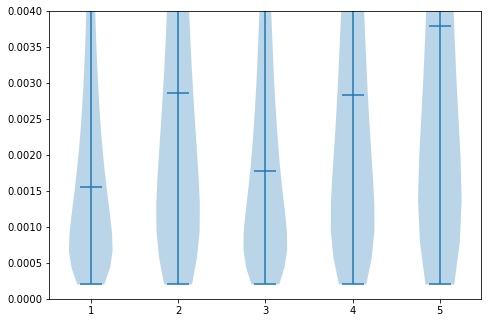

In [27]:
import matplotlib.pyplot as plt
# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(ess_samples, showmedians=True, points=100)
plt.ylim(0,4e-3)
plt.show()

  0%|          | 0/2500 [00:00<?, ?it/s]

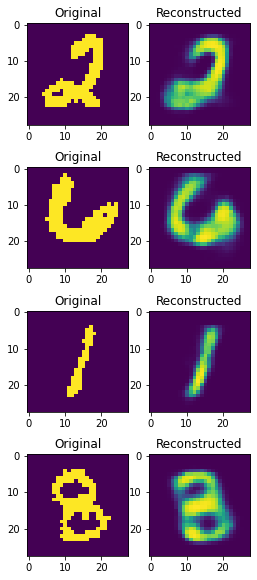

In [14]:
#test_results = train_and_evaluate(model, [optim], train_loader, test_loader, eval_discard(IWAE_loss, M=1, K=64), 6, 10, model_dir+"test")
 
#model.load_state_dict(torch.load(model_dir+'20220404-192054MIWAE8_8_run1_model_epoch6_'))


import matplotlib.pyplot as plt

plt.figure(figsize=(4,26))

for imgs, _ in tqdm(test_loader):
    for i in range(imgs.shape[0]):
        if i >= 10:
            break
        img = imgs[i].view(28 * 28).to(device)
        recon = model.reconstruct(img)
        ax = plt.subplot(10, 2, 2 * i + 1)
        ax.imshow(img.view(28, 28).clone().detach().cpu())
        plt.title("Original")
        ax = plt.subplot(10, 2, 2 * i + 2)
        ax.imshow(recon.view(28, 28).clone().detach().cpu())
        plt.title("Reconstructed")
    break
plt.show()

In [15]:
mnist_train_data.load_all_results()

{'vae': [(1,
      Unnamed: 0  epoch     iwae-64       logpx       -kl
   0           0      1 -200.437149 -200.440903 -0.003757
   1           1     26 -105.979446 -105.978500  0.000944
   2           2     51 -101.402916 -101.399696  0.003228
   3           3     76  -99.660561  -99.666748 -0.006187
   4           4    101  -98.669868  -98.676064 -0.006192
   5           5    126  -97.978683  -97.981720 -0.003027
   6           6    151  -97.534775  -97.539803 -0.005024
   7           7    176  -97.107803  -97.111931 -0.004125
   8           8    200  -96.982994  -96.982079  0.000926)],
 'iwae': [(1,
      Unnamed: 0  epoch     iwae-64       logpx       -kl
   0           0      1 -198.589249 -198.603745 -0.014493
   1           1     26 -113.853149 -113.835800  0.017331
   2           2     51 -108.239548 -108.238937  0.000603
   3           3     76 -106.683678 -106.688759 -0.005092
   4           4    101 -105.249901 -105.262154 -0.012250
   5           5    126 -104.943428 -104.9

In [16]:
def plot_metric(ress: dict, col: str, ax):
    lines = []
    for loss in ress.keys():
        table = ress[loss][0][1]
        epochs = table['epoch']
        metric = table[col]
        line, = ax.plot(epochs, metric, label=loss)
        lines.append(line)
    ax.legend(handles=lines)

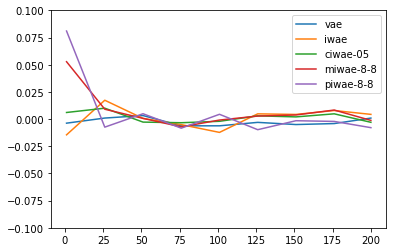

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.ylim([-0.1, 0.1])
plot_metric(mnist_train_data.load_all_results(), '-kl', ax)